# US Drought & Meteorological Data

## Loading the training data
In this section, we load the training and validation data into numpy arrays.

In [9]:
import sys
!{sys.executable} -m pip install numpy pandas sktime sklearn scipy seaborn matplotlib

We load the csv file paths for training, validation and testing into the ``files`` dictionary.

In [18]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
sns.set_style('white')

files = {}

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if 'train' in filename:
            files['train'] = os.path.join(dirname, filename)
        if 'valid' in filename:
            files['valid'] = os.path.join(dirname, filename)
        if 'test' in filename:
            files['test'] = os.path.join(dirname, filename)
            
print(files)

{'test': './test_timeseries.csv', 'train': './train_timeseries.csv', 'valid': './validation_timeseries.csv'}


The following classes exist, ranging from no drought (``None``), to extreme drought (``D4``).
This could be treated as a regression, ordinal or classification problem, but for now we will treat it as 5 distinct classes.

In [19]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

Now we'll define a helper method to load the datasets. This just walks through the json and discards the few samples that are corrupted.

In [20]:
dfs = {
    k: pd.read_csv(files[k]).set_index(['fips', 'date'])
    for k in files.keys()
}

The following are the first 60 days of the first county (1001). As you can see, drought data (last column ``score``) is only provided for on a weekly basis. It will be filled in by our interpolation function defined above.

In [21]:
dfs['train'].head(90)

PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
fips date                                                                 
1001 2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
     2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
     2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
     2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
     2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   
...                  ...     ...    ...    ...     ...     ...      ...   
     2000-03-26     2.92   99.85  10.45  17.14   14.63   14.63    22.80   
     2000-03-27     4.08   98.90   8.91  14.53   11.78   11.78    22.22   
     2000-03-28     0.00   99.07   7.46  14.58    9.10    9.10    24.09   
     2000-03-29     1.77   99.65   8.12  14.82   10.34   10.35    21.28   
     2000-03-30     7.52   99.52  11.90  19.60   16.55   16.54    26.70   

                 T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
fips date                                                                 
1001 2000-01-01    11.46       9.50  14.65   2.20       2.94       1.49   
     2000-01-02    12.61      10.18  16.60   2.52       3.43       1.83   
     2000-01-03    15.32       7.41  18.41   4.03       5.33       2.66   
     2000-01-04     2.16      15.92  11.31   3.84       5.67       2.08   
     2000-01-05    -2.66      13.48   2.65   1.60       2.50       0.52   
...                  ...        ...    ...    ...        ...        ...   
     2000-03-26    13.44       9.35  16.98   1.55       2.00       0.67   
     2000-03-27     7.08      15.14  14.54   2.58       4.73       1.41   
     2000-03-28     5.37      18.71  14.53   2.97       5.13       1.60   
     2000-03-29     8.17      13.11  14.89   1.84       2.67       0.89   
     2000-03-30    13.35      13.35  19.65   2.18       3.20       1.02   

                 WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE   score  
fips date                                                                       
1001 2000-01-01         1.46   4.85       6.04       3.23         2.81     NaN  
     2000-01-02         1.60   5.33       6.13       3.72         2.41     NaN  
     2000-01-03         2.67   7.53       9.52       5.87         3.66     NaN  
     2000-01-04         3.59   6.73       9.31       3.74         5.58  1.0000  
     2000-01-05         1.98   2.94       4.85       0.65         4.19     NaN  
...                      ...    ...        ...        ...          ...     ...  
     2000-03-26         1.33   3.37       5.32       1.13         4.19     NaN  
     2000-03-27         3.32   5.12       7.62       2.72         4.91     NaN  
     2000-03-28         3.53   5.80       8.68       3.52         5.16  1.2818  
     2000-03-29         1.78   3.64       5.34       1.90         3.45     NaN  
     2000-03-30         2.18   4.31       6.42       1.64         4.78     NaN  

[90 rows x 19 columns]

In [22]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

We encode the day of year using sin/cos and add the data loading function `loadXY`.

In [23]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

def loadXY(
    df,
    random_state=42, # keep this at 42
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = pd.read_csv("soil_data.csv")
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

Now we add a helper to normalise the data.

In [24]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

We can now load our training and validation data sets, where X consists of static (soil) and time (meteorological) data and Y consists of the future drought values.

In [25]:
X_static_train, X_time_train, y_target_train = loadXY("train")
print("train shape", X_time_train.shape)
X_static_train, X_time_train = normalize(X_static_train, X_time_train, fit=True)

  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 103390 samples
train shape (103390, 180, 21)


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 8748 samples
validation shape (8748, 180, 21)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [27]:
print('First line of above data frame:')
print(X_time_train[0][0])
print('...')
print('Last line of above data frame:')
print(X_time_train[0][-1])
print()
print('Labels to be predicted:')
print(y_target_train[0])

First line of above data frame:
[ 3.55963303  0.51213592  0.48289474  0.13654618  0.43567961  0.43613139
 -0.00455322  0.28113879 -0.65371025  0.1338227  -0.53252033 -0.48484848
 -0.2345679  -0.48148148 -0.44155844 -0.43501326 -0.2        -0.29166667
  0.8301314   0.67585565 -0.13296077]
...
Last line of above data frame:
[-0.08256881  0.75       -0.5        -0.26965003 -0.63046117 -0.62347932
 -0.20830962 -0.25563464  0.31272085 -0.25239977 -0.07723577 -0.20936639
  0.09876543 -0.29218107  0.16883117 -0.18567639  0.61355932 -0.84469697
  3.91880129 -0.70869533  0.12156313]

Labels to be predicted:
[4.7206 5.     5.     5.     4.     4.    ]


## Visualization and reporting functions

Here, we define some functions for calculating F1-scores as well as printing a beautiful confusion matrices.

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
import warnings

``round_and_intify()`` rounds interpolated drought values like 1.21 into clean integers between 0 and 5.


In [166]:
def round_and_intify(y):
    return np.clip(np.squeeze(y).round().astype('int'), 0, 5)

``bold()`` surrounds a string in **boldness** modifiers for printing

In [167]:
def bold(string):
    return f'\033[1m{string}\033[0m'

``plot_confusion_matrix()`` plots a single seaborn confusion matrix

In [29]:
def plot_confusion_matrix(matrix, labels):
    plt.figure(1, figsize=(8.7, 7))
    ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
    ax.set_xticklabels(labels)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels(labels, rotation=90, va="center")
    ax.set_xlabel("Predicted Label", labelpad=18, fontdict=dict(weight='bold'))
    ax.set_ylabel("True Label", labelpad=15, fontdict=dict(weight='bold'))
    colorax = plt.gcf().axes[-1]
    colorax.tick_params(length=0)
    plt.show()

``plot_confusion_matrices()`` plots a series of six seaborn confusion matrices

In [290]:
def plot_confusion_matrices(matrices, labels, macro_f1s, maes):
    fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(16,4.9))
    for i, (matrix, macro_f1, mae) in enumerate(zip(matrices, macro_f1s, maes)):
        sns.heatmap(matrix, ax=axes[i], annot=True, cmap="YlGnBu", vmin=0, vmax=1, cbar=False)
        axes[i].set_xticklabels(labels)
        axes[i].xaxis.tick_top()
        axes[i].xaxis.set_label_position('top') 
        axes[i].tick_params(axis='both', which='both', length=0)
        axes[i].set_yticklabels(labels, rotation=90, va="center")
        axes[i].text(3, 7.5,f'MAE: {mae}\nMacro F1: {macro_f1}', fontsize=14, ha='center')
        axes[i].set_xlabel(f"Predicted Label\nWeek {i+1}", labelpad=15, fontdict=dict(weight='bold'), fontsize=14)
        axes[0].set_ylabel("True Label", labelpad=12, fontdict=dict(weight='bold'), fontsize=14)
    fig.suptitle(f'MAE: {np.mean([float(x) for x in maes]):.3f}\n' \
                 f'Macro F1: {np.mean([float(x) for x in macro_f1s]):.3f}', 
                 fontsize=14,
                 fontweight='bold',
                 y=0.06)
    fig.tight_layout()
    plt.show()

``summarize()`` prints a series of confusion matrices from (rounded) true and predicted y values

In [291]:
def summarize(y_true, y_pred):
    weeks_true = np.split(y_true, 6, 1)
    weeks_pred = np.split(y_pred, 6, 1)
    matrices = []
    macro_f1s = []
    maes = []
    for y_true, y_pred in zip(weeks_true, weeks_pred):
        y_true = round_and_intify(y_true.flatten())
        y_pred = round_and_intify(y_pred.flatten())
        matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')
        matrices += [matrix]
        report = metrics.classification_report(y_true, y_pred, digits=3)
        r = re.compile('(?<=macro avg\s{6}\d.\d{3}\s{5}\d.\d{3}\s{5})\d.\d{3}')
        macro_f1s += [r.search(report).group(0)]
        maes += [f"{np.mean(abs(y_true - y_pred)):.3f}"]
    warnings.filterwarnings('ignore')
    labels = ["None", "D0", "D1", "D2", "D3", "D4"]
    plot_confusion_matrices(matrices, labels, macro_f1s, maes)
    
#     print(metrics.classification_report(y_true, y_pred, digits=3)
#           .replace('precision', '    precision')
#           .replace('\n', '\n    ')
#           .replace('f1-score', bold('f1-score'))
#           .replace('   0 ', bold('None '))
#           .replace('   1 ', bold('  D0 '))
#           .replace('   2 ', bold('  D1 '))
#           .replace('   3 ', bold('  D2 '))
#           .replace('   4 ', bold('  D3 '))
#           .replace('   5 ', bold('  D4 '))
#           .replace('       accuracy', bold('(micro avg) acc'))
#           .replace('macro avg', bold('macro avg'))
#          )

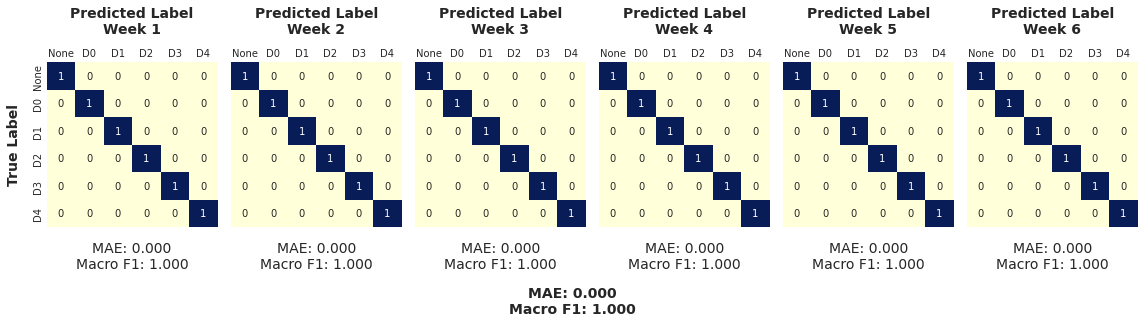

In [292]:
summarize(y_target_valid, y_target_valid)

## Transforming with ROCKET

Here, we transform our time series with some convolutional kernels using MiniROCKET.

ROCKET produces ~10.000 values for each time series, not matter its length.

The ``fit()`` function name is misleading, as ROCKET needs **no training at all**. It merely adjusts it for the multivariate dimensions.

In [83]:
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_time_train)

MiniRocketMultivariate()

In [34]:
X_train = minirocket_multi.transform(X_time_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
0,0.285714,0.380952,0.095238,0.380952,0.523810,0.190476,0.380952,0.095238,0.285714,0.380952,...,0.619048,0.142857,0.476190,0.761905,0.333333,0.476190,0.904762,0.380952,0.714286,0.142857
1,0.285714,0.571429,0.142857,0.380952,0.666667,0.238095,0.571429,0.047619,0.333333,0.571429,...,0.761905,0.142857,0.476190,0.761905,0.238095,0.571429,0.857143,0.380952,0.761905,0.142857
2,0.238095,0.476190,0.142857,0.285714,0.857143,0.190476,0.476190,0.142857,0.285714,0.619048,...,0.619048,0.000000,0.428571,0.619048,0.285714,0.571429,0.809524,0.380952,0.619048,0.047619
3,0.142857,0.571429,0.142857,0.285714,0.761905,0.142857,0.523810,0.047619,0.142857,0.666667,...,0.761905,0.000000,0.571429,0.761905,0.142857,0.619048,0.904762,0.476190,0.761905,0.000000
4,0.380952,0.523810,0.285714,0.428571,0.619048,0.333333,0.476190,0.142857,0.380952,0.571429,...,0.619048,0.000000,0.476190,0.666667,0.238095,0.619048,0.761905,0.428571,0.666667,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103385,0.428571,0.428571,0.333333,0.428571,0.523810,0.428571,0.428571,0.333333,0.428571,0.428571,...,0.952381,0.190476,0.714286,1.000000,0.285714,0.857143,1.000000,0.476190,1.000000,0.238095
103386,0.333333,0.523810,0.190476,0.428571,0.619048,0.285714,0.523810,0.142857,0.333333,0.523810,...,0.857143,0.238095,0.714286,0.857143,0.476190,0.761905,1.000000,0.619048,0.857143,0.285714
103387,0.142857,0.523810,0.142857,0.142857,0.809524,0.142857,0.428571,0.142857,0.142857,0.571429,...,0.761905,0.238095,0.571429,0.952381,0.333333,0.714286,1.000000,0.428571,0.952381,0.285714
103388,0.285714,0.380952,0.190476,0.380952,0.523810,0.285714,0.380952,0.142857,0.285714,0.428571,...,0.809524,0.333333,0.714286,1.000000,0.571429,0.714286,1.000000,0.666667,0.952381,0.523810


As you can see, we now have ~10.000 features per time series.

Finally, we concatenate the fixed-size data on soil quality etc. to the ROCKET features. 

In [37]:
print(X_train.shape)
print(X_static_train.shape)

X_train = np.concatenate((X_train, X_static_train), axis=1)

print(X_train.shape)

(103390, 10026)
(103390, 30)
(103390, 10056)


## Loading the validation data

Here we load the validation data and transform the time series data into ROCKET features, just like for the training data.

Then, we concatenate the fixed-size data on soil quality etc. to the ROCKET features. 

In [38]:
X_static_valid, X_time_valid, y_target_valid = loadXY("valid")
print("validation shape", X_time_valid.shape)
X_static_valid, X_time_valid = normalize(X_static_valid, X_time_valid)
X_valid = minirocket_multi.transform(X_time_valid)

  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 8748 samples
validation shape (8748, 180, 21)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
print(X_valid.shape)
print(X_static_valid.shape)

X_valid = np.concatenate((X_valid, X_static_valid), axis=1)

print(X_valid.shape)

(8748, 9996)
(8748, 30)
(8748, 10026)


## Goal: perfect classification

The following is a report that shows perfect classification of our samples. This is the ideal we want to achieve, just so you know what to look for.

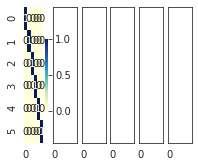

In [100]:
summarize(y_target_valid, y_target_valid)

<div class="alert alert-success">Benchmark I</div>

## Random: always predict a random class

Here we check what the results are for always predicting a random class between 0 and 5.

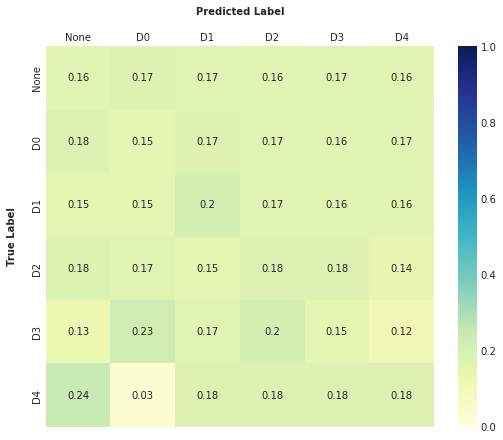

                  precision    recall  f1-score   support
    
            None      0.655     0.164     0.262      5799
              D0      0.167     0.152     0.160      1620
              D1      0.106     0.204     0.140       779
              D2      0.047     0.179     0.075       380
              D3      0.014     0.153     0.026       137
              D4      0.004     0.182     0.008        33
    
 (micro avg) acc                          0.166      8748
       macro avg      0.166     0.172     0.112      8748
    weighted avg      0.477     0.166     0.220      8748
    


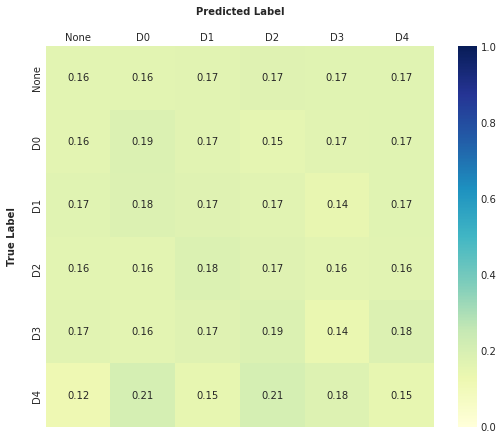

                  precision    recall  f1-score   support
    
            None      0.661     0.160     0.258      5790
              D0      0.208     0.187     0.197      1630
              D1      0.090     0.173     0.118       765
              D2      0.046     0.174     0.073       390
              D3      0.013     0.137     0.024       139
              D4      0.003     0.147     0.007        34
    
 (micro avg) acc                          0.167      8748
       macro avg      0.170     0.163     0.113      8748
    weighted avg      0.486     0.167     0.222      8748
    


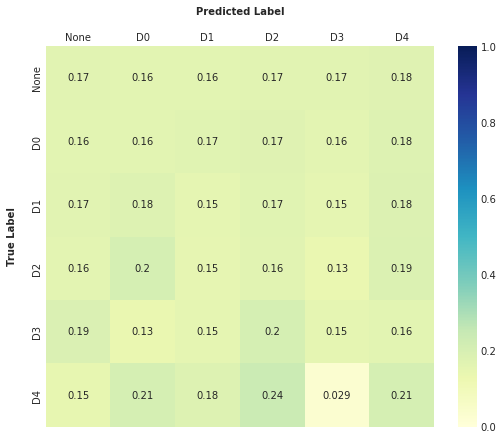

                  precision    recall  f1-score   support
    
            None      0.668     0.168     0.268      5801
              D0      0.178     0.160     0.169      1608
              D1      0.083     0.154     0.108       767
              D2      0.044     0.164     0.070       396
              D3      0.016     0.155     0.028       142
              D4      0.005     0.206     0.009        34
    
 (micro avg) acc                          0.165      8748
       macro avg      0.166     0.168     0.109      8748
    weighted avg      0.485     0.165     0.222      8748
    


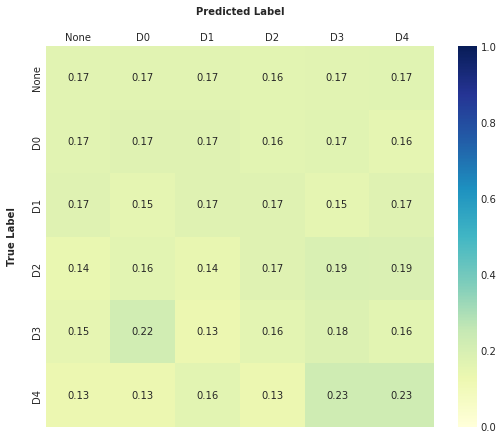

                  precision    recall  f1-score   support
    
            None      0.671     0.167     0.267      5829
              D0      0.185     0.174     0.179      1556
              D1      0.095     0.173     0.123       796
              D2      0.047     0.175     0.074       383
              D3      0.019     0.183     0.035       153
              D4      0.005     0.226     0.009        31
    
 (micro avg) acc                          0.169      8748
       macro avg      0.170     0.183     0.114      8748
    weighted avg      0.491     0.169     0.225      8748
    


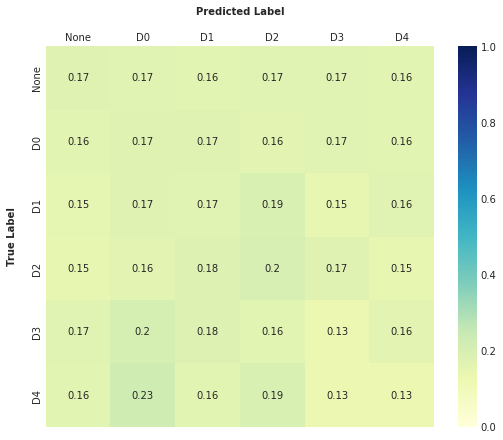

                  precision    recall  f1-score   support
    
            None      0.687     0.173     0.276      5838
              D0      0.180     0.172     0.176      1538
              D1      0.095     0.169     0.122       809
              D2      0.051     0.197     0.081       385
              D3      0.013     0.129     0.024       147
              D4      0.003     0.129     0.005        31
    
 (micro avg) acc                          0.173      8748
       macro avg      0.172     0.162     0.114      8748
    weighted avg      0.502     0.173     0.231      8748
    


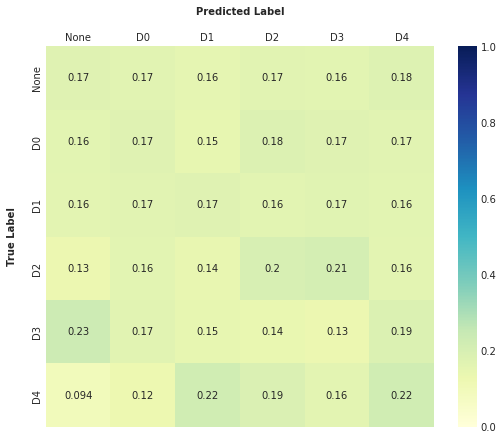

                  precision    recall  f1-score   support
    
            None      0.683     0.173     0.276      5828
              D0      0.183     0.174     0.178      1540
              D1      0.104     0.175     0.130       806
              D2      0.052     0.197     0.082       391
              D3      0.014     0.132     0.025       151
              D4      0.005     0.219     0.009        32
    
 (micro avg) acc                          0.174      8748
       macro avg      0.173     0.178     0.117      8748
    weighted avg      0.499     0.174     0.231      8748
    


In [85]:
summarize(y_target_valid, np.random.randint(6, size=y_target_valid.shape))

## Majority class: always predict no drought

Here we check what the results are for always predicting the majority class, which is 'no drought' (0).

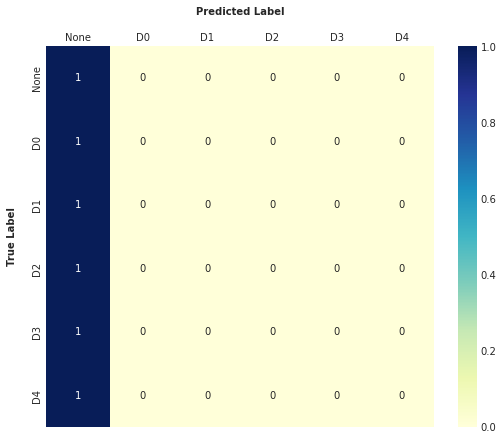

                  precision    recall  f1-score   support
    
            None      0.663     1.000     0.797      5799
              D0      0.000     0.000     0.000      1620
              D1      0.000     0.000     0.000       779
              D2      0.000     0.000     0.000       380
              D3      0.000     0.000     0.000       137
              D4      0.000     0.000     0.000        33
    
 (micro avg) acc                          0.663      8748
       macro avg      0.110     0.167     0.133      8748
    weighted avg      0.439     0.663     0.529      8748
    


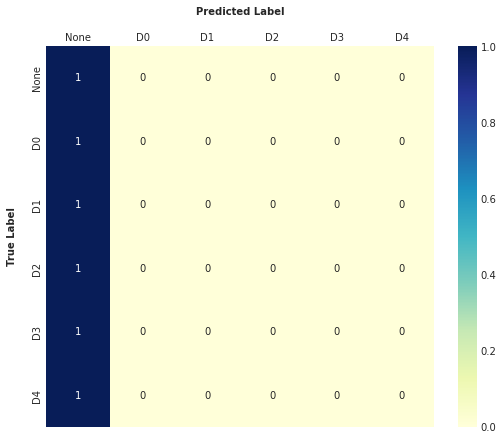

                  precision    recall  f1-score   support
    
            None      0.662     1.000     0.797      5790
              D0      0.000     0.000     0.000      1630
              D1      0.000     0.000     0.000       765
              D2      0.000     0.000     0.000       390
              D3      0.000     0.000     0.000       139
              D4      0.000     0.000     0.000        34
    
 (micro avg) acc                          0.662      8748
       macro avg      0.110     0.167     0.133      8748
    weighted avg      0.438     0.662     0.527      8748
    


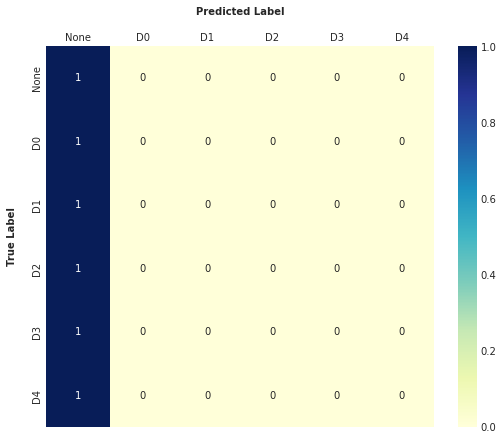

                  precision    recall  f1-score   support
    
            None      0.663     1.000     0.797      5801
              D0      0.000     0.000     0.000      1608
              D1      0.000     0.000     0.000       767
              D2      0.000     0.000     0.000       396
              D3      0.000     0.000     0.000       142
              D4      0.000     0.000     0.000        34
    
 (micro avg) acc                          0.663      8748
       macro avg      0.111     0.167     0.133      8748
    weighted avg      0.440     0.663     0.529      8748
    


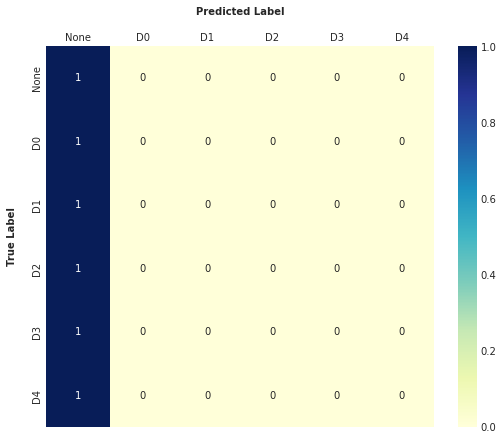

                  precision    recall  f1-score   support
    
            None      0.666     1.000     0.800      5829
              D0      0.000     0.000     0.000      1556
              D1      0.000     0.000     0.000       796
              D2      0.000     0.000     0.000       383
              D3      0.000     0.000     0.000       153
              D4      0.000     0.000     0.000        31
    
 (micro avg) acc                          0.666      8748
       macro avg      0.111     0.167     0.133      8748
    weighted avg      0.444     0.666     0.533      8748
    


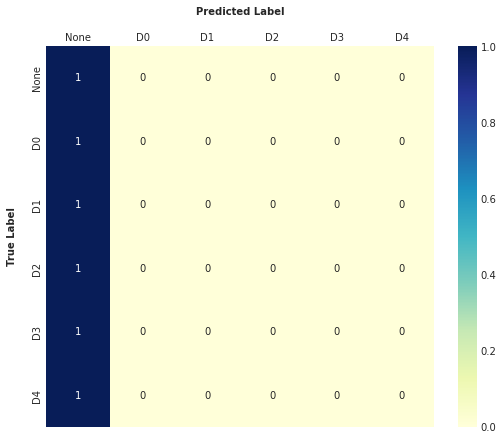

                  precision    recall  f1-score   support
    
            None      0.667     1.000     0.800      5838
              D0      0.000     0.000     0.000      1538
              D1      0.000     0.000     0.000       809
              D2      0.000     0.000     0.000       385
              D3      0.000     0.000     0.000       147
              D4      0.000     0.000     0.000        31
    
 (micro avg) acc                          0.667      8748
       macro avg      0.111     0.167     0.133      8748
    weighted avg      0.445     0.667     0.534      8748
    


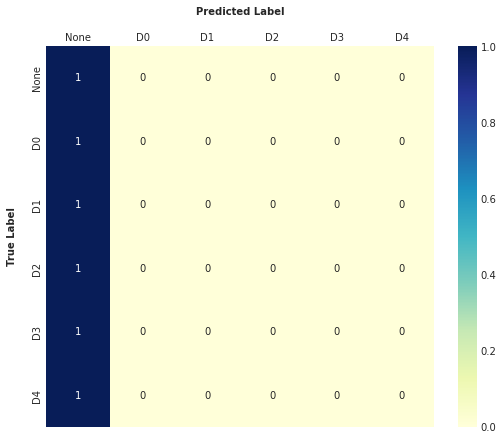

                  precision    recall  f1-score   support
    
            None      0.666     1.000     0.800      5828
              D0      0.000     0.000     0.000      1540
              D1      0.000     0.000     0.000       806
              D2      0.000     0.000     0.000       391
              D3      0.000     0.000     0.000       151
              D4      0.000     0.000     0.000        32
    
 (micro avg) acc                          0.666      8748
       macro avg      0.111     0.167     0.133      8748
    weighted avg      0.444     0.666     0.533      8748
    


In [86]:
summarize(y_target_valid, np.zeros_like(y_target_valid))

## Random (stratified): predict a random class based on true priors

Here we check what the results are for always predicting a random class between 0 and 5, according to how often they appear.

In [87]:
total = len(y_target_train)
print(f"{bold('Total')}:  {total}  (100%)")
for x, count in zip(np.unique(round_and_intify(y_target_train), return_counts=True)[0],
                    np.unique(round_and_intify(y_target_train), return_counts=True)[1]):
    print(f"    {bold(x)}:  {count:6}  ({count/total:.4f}%)")

Total:  103390  (100%)
    0:  375565  (3.6325%)
    1:  103965  (1.0056%)
    2:   64910  (0.6278%)
    3:   42728  (0.4133%)
    4:   24262  (0.2347%)
    5:    8910  (0.0862%)


In [88]:
stratified = np.random.choice(6, len(y_target_valid), p=[0.6029, 0.1665, 0.1083, 0.0695, 0.0388, 0.0140])
summarize(y_target_valid, stratified)

IndexError: tuple index out of range

## Ridge classification

Here, we train a ridge classifier on the ROCKET features.

In [25]:
from sklearn.linear_model import RidgeClassifier

classifier = RidgeClassifier(alpha=0.5, normalize=True)
classifier.fit(X_train, round_and_intify(y_target_train))

RidgeClassifier(alpha=0.5, normalize=True)

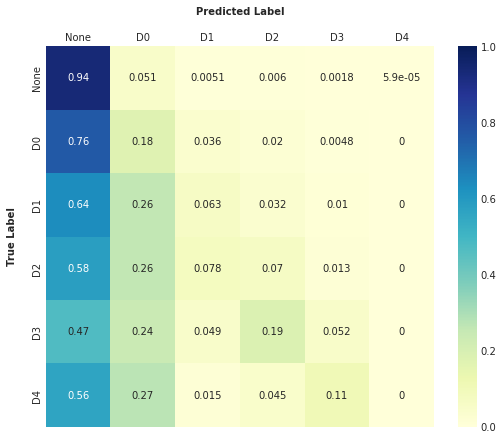

                  precision    recall  f1-score   support
    
            None      0.741     0.936     0.827     16939
              D0      0.316     0.175     0.225      4570
              D1      0.296     0.063     0.104      2194
              D2      0.146     0.070     0.094       790
              D3      0.147     0.052     0.077       305
              D4      0.000     0.000     0.000        66
    
 (micro avg) acc                          0.678     24864
       macro avg      0.274     0.216     0.221     24864
    weighted avg      0.596     0.678     0.618     24864
    


In [26]:
y_pred_valid = classifier.predict(X_valid)

summarize(y_target_valid, y_pred_valid)

## Ridge regression

Here, we don't train a ridge classifier, but a ridge regressor. The predictions then get rounded afterwards.

In [27]:
from sklearn.linear_model import Ridge

ridgeRegressor = Ridge(alpha=0.5, normalize=True)
ridgeRegressor.fit(X_train, np.squeeze(y_target_train))

Ridge(alpha=0.5, normalize=True)

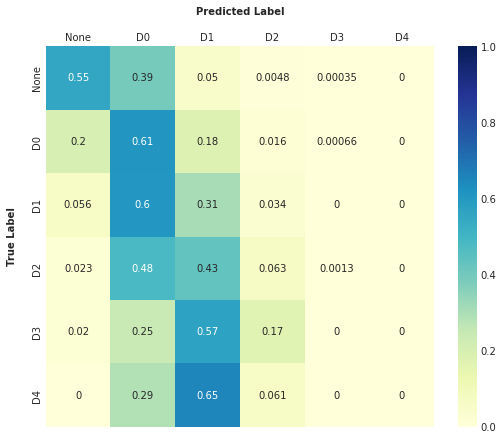

                  precision    recall  f1-score   support
    
            None      0.900     0.554     0.686     16939
              D0      0.248     0.607     0.352      4570
              D1      0.232     0.305     0.263      2194
              D2      0.150     0.063     0.089       790
              D3      0.000     0.000     0.000       305
              D4      0.000     0.000     0.000        66
    
 (micro avg) acc                          0.518     24864
       macro avg      0.255     0.255     0.232     24864
    weighted avg      0.684     0.518     0.558     24864
    


In [28]:
y_pred_valid = ridgeRegressor.predict(X_valid)

summarize(y_target_valid, y_pred_valid)

## Linear regression

Here, we use a plain linear regressor without normalization. The predictions get rounded afterwards.

In [29]:
from sklearn.linear_model import LinearRegression

linearRegressor = LinearRegression(normalize=True)
linearRegressor.fit(X_train, np.squeeze(y_target_train))

LinearRegression(normalize=True)

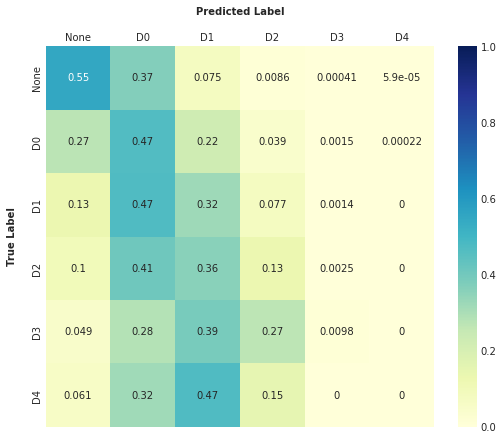

                  precision    recall  f1-score   support
    
            None      0.851     0.547     0.666     16939
              D0      0.216     0.465     0.295      4570
              D1      0.205     0.320     0.250      2194
              D2      0.150     0.130     0.139       790
              D3      0.136     0.010     0.018       305
              D4      0.000     0.000     0.000        66
    
 (micro avg) acc                          0.491     24864
       macro avg      0.260     0.246     0.228     24864
    weighted avg      0.644     0.491     0.535     24864
    


In [30]:
y_pred_valid = linearRegressor.predict(X_valid)

summarize(y_target_valid, y_pred_valid)

## Ridge regression, squared X

It seems as our model is still very hesitant to vote for classes D2, D3 and D4. We want to punish it harder for mistakes on these classes by increasing their distance to the lower classes. We do this by squaring all Y values. So instad of 0,1,2,3,4,5 we now have 0,1,4,9,16,25. 

After regression, we take the square root of the predictions to get our 'true' classes again.

In [31]:
from sklearn.linear_model import Ridge

ridgeRegressor = Ridge(alpha=0.5, normalize=True)
ridgeRegressor.fit(X_train, np.square(np.squeeze(y_target_train)))

Ridge(alpha=0.5, normalize=True)

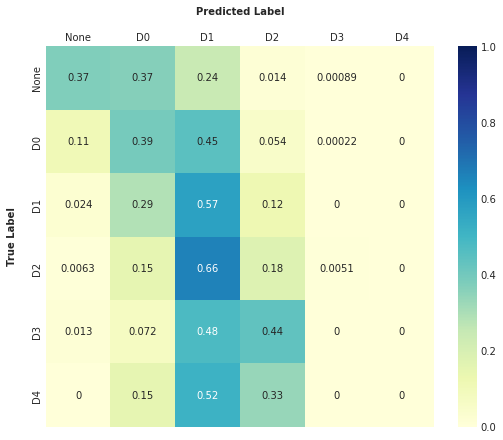

                  precision    recall  f1-score   support
    
            None      0.919     0.374     0.532     16939
              D0      0.204     0.391     0.268      4570
              D1      0.154     0.571     0.242      2194
              D2      0.135     0.178     0.154       790
              D3      0.000     0.000     0.000       305
              D4      0.000     0.000     0.000        66
    
 (micro avg) acc                          0.383     24864
       macro avg      0.235     0.252     0.199     24864
    weighted avg      0.681     0.383     0.438     24864
    


In [32]:
y_pred_valid = ridgeRegressor.predict(X_valid)

summarize(y_target_valid, np.sqrt(y_pred_valid))